# Modeling the data

The target values that we are intersted in are the relative number of threatened species per group and the relative numbers of the trend.
For this we create a model for each target value und capture the RMSE and MAE for each model. As the goal is to see the predicitve power of the models we do not perform exhaustive hyperparameter optimization but only run a Grid Search by model and use the model with the best observed RMSE. The best params per target are reported.

We use Leave on Out CV for the model because we are limited in the number of observations (countries)

ToDo
- why levae one out
- why KNN (simple model)
- remov Unknown trend

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# load all datasets
def load_created_datasets():
    data_list = []
    DATA_PATH = Path('./data/created/')
    
    file_paths = DATA_PATH.glob('*.csv')
    for file_path in file_paths:
        df = pd.read_csv(file_path, index_col='Country')
        data_list.append(df)
    return pd.concat(data_list, join='inner', axis=1)
data = load_created_datasets()
data.shape

(42, 43)

In [3]:
data.columns

Index(['Artificial surfaces', 'Bare area', 'Cropland', 'Grassland',
       'Inland water', 'Shrubland', 'Sparse vegetation', 'Tree cover',
       'Wetland', 'perc_area_protected_all_obj', 'perc_area_protected_obj_2',
       'perc_area_protected_obj_3', 'perc_area_protected_obj_4',
       'perc_area_protected_obj_1a', 'perc_area_protected_obj_1b',
       'perc_area_protected_no_obj', 'perc_area_protected_obj_5',
       'perc_area_protected_obj_6', 'temp_slope', 'gain_percentage',
       'temp_difference', 'decreasing_trend', 'increasing_trend',
       'stable_trend', 'Unnamed: 0', 'CH4', 'CO2', 'HFC', 'N2O', 'NF3', 'PFC',
       'SF6', 'total_threatened', 'mammals_threatened', 'insects_threatened',
       'amphibians_threatened', 'birds_threatened', 'reptiles_threatened',
       'mammals_resident', 'insects_resident', 'amphibians_resident',
       'birds_resident', 'reptiles_resident'],
      dtype='object')

In [4]:
# todo: why 42 I thought we only have 37 equal county names

In [5]:
data.describe()

,Artificial surfaces,Bare area,Cropland,Grassland,Inland water,Shrubland,Sparse vegetation,Tree cover,Wetland,perc_area_protected_all_obj,...,N2O,NF3,PFC,SF6,total_threatened,mammals_threatened,insects_threatened,amphibians_threatened,birds_threatened,reptiles_threatened
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.026339,0.038424,0.310657,0.119879,0.024451,0.046523,0.042569,0.372816,0.018343,22.282857,...,0.586226,-0.666490,-0.154093,-0.036179,0.090214,0.101226,0.093860,0.127510,0.058579,0.113638
std,0.027342,0.101581,0.200676,0.146812,0.025092,0.089805,0.090189,0.200493,0.028890,10.766357,...,0.349903,0.477372,0.384327,0.219119,0.059176,0.069002,0.059323,0.179915,0.042883,0.150635
min,0.000000,0.000000,0.000000,0.000538,0.001644,0.000000,0.000000,0.000277,0.000000,5.640000,...,0.092906,-1.000000,-1.000000,-1.000000,0.016700,0.000000,0.000000,0.000000,0.016000,0.000000
25%,0.005924,0.000336,0.129256,0.037745,0.010373,0.000000,0.000336,0.240079,0.001003,14.287500,...,0.345235,-1.000000,0.000021,0.002429,0.050675,0.051750,0.065525,0.000000,0.038250,0.000000
50%,0.015773,0.003751,0.284342,0.067105,0.016106,0.001209,0.004243,0.359648,0.003297,20.370000,...,0.481730,-1.000000,0.003712,0.007283,0.071400,0.089700,0.086850,0.032150,0.044300,0.077000
75%,0.040661,0.025580,0.453853,0.145471,0.023636,0.042408,0.026137,0.531033,0.020536,27.892500,...,0.849686,0.000009,0.012341,0.010464,0.124150,0.142075,0.103925,0.209625,0.064075,0.158400
max,0.113337,0.566080,0.728131,0.672711,0.105244,0.352494,0.357313,0.714984,0.123473,53.530000,...,1.554079,0.002234,0.216726,0.128989,0.357500,0.294000,0.304300,0.750000,0.290000,0.750000


In [6]:
data.columns

Index(['Artificial surfaces', 'Bare area', 'Cropland', 'Grassland',
       'Inland water', 'Shrubland', 'Sparse vegetation', 'Tree cover',
       'Wetland', 'perc_area_protected_all_obj', 'perc_area_protected_obj_2',
       'perc_area_protected_obj_3', 'perc_area_protected_obj_4',
       'perc_area_protected_obj_1a', 'perc_area_protected_obj_1b',
       'perc_area_protected_no_obj', 'perc_area_protected_obj_5',
       'perc_area_protected_obj_6', 'temp_slope', 'gain_percentage',
       'temp_difference', 'decreasing_trend', 'increasing_trend',
       'stable_trend', 'Unnamed: 0', 'CH4', 'CO2', 'HFC', 'N2O', 'NF3', 'PFC',
       'SF6', 'total_threatened', 'mammals_threatened', 'insects_threatened',
       'amphibians_threatened', 'birds_threatened', 'reptiles_threatened',
       'mammals_resident', 'insects_resident', 'amphibians_resident',
       'birds_resident', 'reptiles_resident'],
      dtype='object')

In [7]:
# are there any missing numbers
data.isna().any().sum()

0

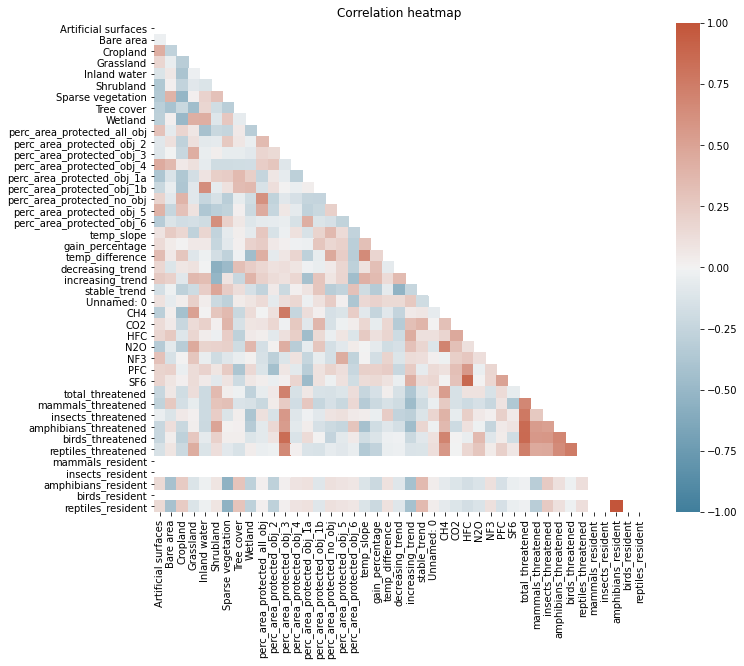

In [8]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Compute the correlation matrix
corr = data.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

# Logistic regression

In [9]:
def knn_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('knn', KNeighborsRegressor())
        ])

        # define grid search parameters
        params = {
            'knn__n_neighbors': [1, 2, 3 , 4 , 5],
            'knn__weights': ['uniform', 'distance']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

knn_cv_results = knn_by_target(data)

In [10]:
def extract_from_cv_results(cv_results, row_name=None):
    cv_results = pd.DataFrame(cv_results)
    best_scores = {}
    best_params = {}

    scores = [col.replace('mean_test_', '') for col in cv_results.columns if col.startswith('mean_test_')]
    params = [col for col in cv_results.columns if col.startswith('param_')]

    for score in scores:
        best_params[score] = {}
        # rank is 1 for multiple models if score is equal
        best_model_by_score = cv_results[cv_results[f'rank_test_{score}'] == 1].iloc[0]
        best_scores[f'mean_{score}'] = best_model_by_score[f'mean_test_{score}']
        best_scores[f'std_{score}'] = best_model_by_score[f'std_test_{score}']
        for param in params:
            p = param.split('__')[-1]
            best_params[score][p] = best_model_by_score[param]
    
    best_params = pd.DataFrame(best_params)
    if row_name is None:
        best_scores = pd.DataFrame(best_scores, index=['value'])
    else:
        best_scores = pd.DataFrame(best_scores, index=[row_name])
        best_params['target'] = row_name
        best_params = best_params.reset_index().set_index(['target', 'index'])
    return best_scores, best_params

In [11]:
def results_by_target(data, cv_results_by_target):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    best_scores = []
    best_params = []
    for target in target_columns:
        scores, params = extract_from_cv_results(cv_results_by_target[target], target)
        best_scores.append(scores)
        best_params.append(params)

    best_scores = pd.concat(best_scores)
    best_scores = best_scores.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'std_neg_root_mean_squared_error': 'RMSE_var',
        'mean_neg_mean_absolute_error': 'MAE',
        'std_neg_mean_absolute_error': 'MAE_var'
    })
    best_scores[['RMSE', 'MAE']] = best_scores[['RMSE', 'MAE']].apply(lambda x: -x)
    best_scores[['RMSE_var', 'MAE_var']] = best_scores[['RMSE_var', 'MAE_var']].apply(lambda x: x**2)

    best_params = pd.concat(best_params)
    best_params = best_params.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'mean_neg_mean_absolute_error': 'MAE',
    })

    return best_scores, best_params

In [12]:
knn_best_scores, knn_best_params = results_by_target(data, knn_cv_results)

In [13]:
knn_best_scores

,RMSE,RMSE_var,MAE,MAE_var
decreasing_trend,0.026221,0.000694,0.026221,0.000694
increasing_trend,0.026979,0.000488,0.026979,0.000488
stable_trend,0.032464,0.002008,0.032464,0.002008
total_threatened,0.038853,0.002286,0.038853,0.002286
mammals_threatened,0.047012,0.001846,0.047012,0.001846
insects_threatened,0.043969,0.001833,0.043969,0.001833
amphibians_threatened,0.108114,0.019756,0.108114,0.019756
birds_threatened,0.020978,0.001605,0.020978,0.001605
reptiles_threatened,0.076755,0.014940,0.076755,0.014940


In [14]:
knn_best_params

neg_root_mean_squared_error  \
target                index                                     
decreasing_trend      n_neighbors                           3   
                      weights                         uniform   
increasing_trend      n_neighbors                           1   
                      weights                         uniform   
stable_trend          n_neighbors                           1   
                      weights                         uniform   
total_threatened      n_neighbors                           2   
                      weights                        distance   
mammals_threatened    n_neighbors                           1   
                      weights                         uniform   
insects_threatened    n_neighbors                           2   
                      weights                         uniform   
amphibians_threatened n_neighbors                           1   
                      weights                         uniform   
birds_threatened      n_neighbors                           2   
                      weights                        distance   
reptiles_threatened   n_neighbors                           1   
                      weights                         uniform   

                                  neg_mean_absolute_error  
target                index                                
decreasing_trend      n_neighbors                       3  
                      weights                     uniform  
increasing_trend      n_neighbors                       1  
                      weights                     uniform  
stable_trend          n_neighbors                       1  
                      weights                     uniform  
total_threatened      n_neighbors                       2  
                      weights                    distance  
mammals_threatened    n_neighbors                       1  
                      weights                     uniform  
insects_threatened    n_neighbors                       2  
                      weights                     uniform  
amphibians_threatened n_neighbors                       1  
                      weights                     uniform  
birds_threatened      n_neighbors                       2  
                      weights                    distance  
reptiles_threatened   n_neighbors                       1  
                      weights                     uniform

In [15]:
def extract_cv_scores(data, cv_results, score):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    results_by_target = {}
    for target in target_columns:
        results = pd.DataFrame(cv_results[target])
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(data.shape[0])]
        cv_scores = [-val for val in cv_scores]
        results_by_target[target] = cv_scores
    return pd.DataFrame(results_by_target)

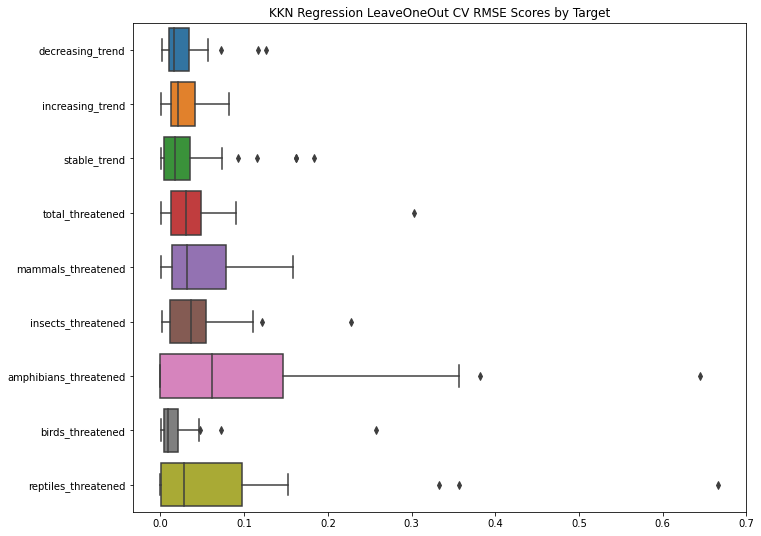

In [16]:
# get data
vis_knn_scores = extract_cv_scores(data, knn_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('KKN Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

# Support Vector Regression

We select support vector regression mainly because they are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.

In [17]:
def svr_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('svr', SVR())
        ])

        # define grid search parameters
        params = {
            'svr__C': [0.1, 0.3, 0.5, 0.8, 1, 2, 5],
            'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

svr_cv_results = svr_by_target(data)

In [18]:
svr_best_scores, svr_best_params = results_by_target(data, svr_cv_results)

In [19]:
svr_best_scores

,RMSE,RMSE_var,MAE,MAE_var
decreasing_trend,0.052288,0.000523,0.052288,0.000523
increasing_trend,0.037449,0.001038,0.037449,0.001038
stable_trend,0.056199,0.001380,0.056199,0.001380
total_threatened,0.060051,0.002026,0.060051,0.002026
mammals_threatened,0.057866,0.001579,0.057866,0.001579
insects_threatened,0.056429,0.001800,0.056429,0.001800
amphibians_threatened,0.109784,0.009475,0.109784,0.009475
birds_threatened,0.072356,0.001486,0.072356,0.001486
reptiles_threatened,0.096735,0.009524,0.096735,0.009524


In [20]:
svr_best_params

neg_root_mean_squared_error  \
target                index                                
decreasing_trend      C                              0.1   
                      kernel                      linear   
increasing_trend      C                              0.1   
                      kernel                     sigmoid   
stable_trend          C                              0.1   
                      kernel                         rbf   
total_threatened      C                              0.1   
                      kernel                        poly   
mammals_threatened    C                              0.1   
                      kernel                      linear   
insects_threatened    C                              0.1   
                      kernel                     sigmoid   
amphibians_threatened C                              0.1   
                      kernel                      linear   
birds_threatened      C                              0.3   
                      kernel                     sigmoid   
reptiles_threatened   C                              0.1   
                      kernel                     sigmoid   

                             neg_mean_absolute_error  
target                index                           
decreasing_trend      C                          0.1  
                      kernel                  linear  
increasing_trend      C                          0.1  
                      kernel                 sigmoid  
stable_trend          C                          0.1  
                      kernel                     rbf  
total_threatened      C                          0.1  
                      kernel                    poly  
mammals_threatened    C                          0.1  
                      kernel                  linear  
insects_threatened    C                          0.1  
                      kernel                 sigmoid  
amphibians_threatened C                          0.1  
                      kernel                  linear  
birds_threatened      C                          0.3  
                      kernel                 sigmoid  
reptiles_threatened   C                          0.1  
                      kernel                 sigmoid

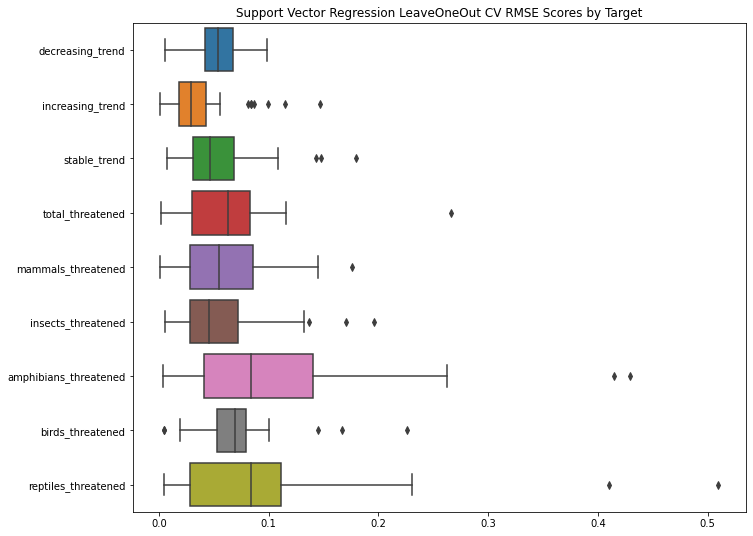

In [21]:
# get data
vis_knn_scores = extract_cv_scores(data, svr_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Support Vector Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

## Compare Models

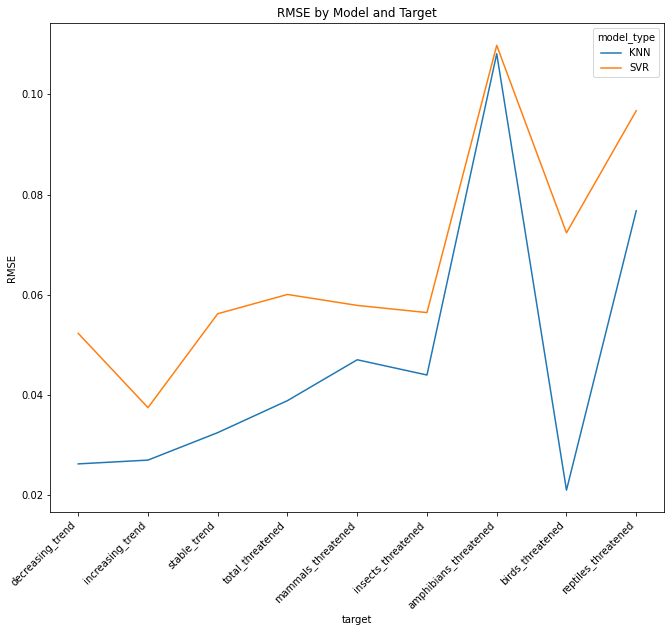

In [22]:
# prepare data for visualization
vis_knn = knn_best_scores.reset_index().rename(columns={'index': 'target'})
vis_knn['model_type'] = 'KNN'
vis_svr = svr_best_scores.reset_index().rename(columns={'index': 'target'})
vis_svr['model_type'] = 'SVR'
df =pd.concat([vis_knn, vis_svr])

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('RMSE by Model and Target')

# create heatmap
sns.lineplot(data=df, x='target', y='RMSE', hue='model_type')
plt.xticks(rotation=45, ha='right')
plt.show()